<a href="https://colab.research.google.com/github/ashutoshb206/capstone_project_iitg/blob/main/Capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('dataset.csv')  # Adjust path if needed

# Check first few rows
df.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [ ]:
# Filter data for a sample parking lot (you can change the lot later)
lot_id = 'BHMBCCMKT01'  # Example lot
lot_data = df[df['SystemCodeNumber'] == lot_id].copy()

# Sort by date and time to maintain correct order
lot_data = lot_data.sort_values(by=['LastUpdatedDate', 'LastUpdatedTime']).reset_index(drop=True)

# Show first few records for this lot
lot_data.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,468,BHMBCCMKT01,577,26.144536,91.736172,50,car,low,1,0,01-11-2016,08:06:00
1,469,BHMBCCMKT01,577,26.144536,91.736172,54,car,low,1,0,01-11-2016,08:26:00
2,470,BHMBCCMKT01,577,26.144536,91.736172,69,car,average,2,0,01-11-2016,09:00:00
3,471,BHMBCCMKT01,577,26.144536,91.736172,91,car,low,1,0,01-11-2016,09:26:00
4,472,BHMBCCMKT01,577,26.144536,91.736172,135,truck,average,3,0,01-11-2016,10:00:00


In [ ]:
# Parameters
base_price = 10.0  # starting price
alpha = 2.0        # sensitivity factor, you can tune this later

# Initialize price list with base price
prices = [base_price]

# Iterate through each time point to compute next price
for i in range(1, len(lot_data)):
    occupancy = lot_data.loc[i, 'Occupancy']
    capacity = lot_data.loc[i, 'Capacity']

    price_prev = prices[-1]
    price_new = price_prev + alpha * (occupancy / capacity)

    prices.append(price_new)

# Add prices to dataframe
lot_data['Price_Model1'] = prices

# Show some results
lot_data[['LastUpdatedDate', 'LastUpdatedTime', 'Occupancy', 'Price_Model1']].head(10)


,LastUpdatedDate,LastUpdatedTime,Occupancy,Price_Model1
0,01-11-2016,08:06:00,50,10.000000
1,01-11-2016,08:26:00,54,10.187175
2,01-11-2016,09:00:00,69,10.426343
3,01-11-2016,09:26:00,91,10.741768
4,01-11-2016,10:00:00,135,11.209705
5,01-11-2016,10:26:00,163,11.774697
6,01-11-2016,11:00:00,185,12.415945
7,01-11-2016,11:26:00,207,13.133449
8,01-11-2016,12:00:00,239,13.961872
9,01-11-2016,12:26:00,244,14.807626


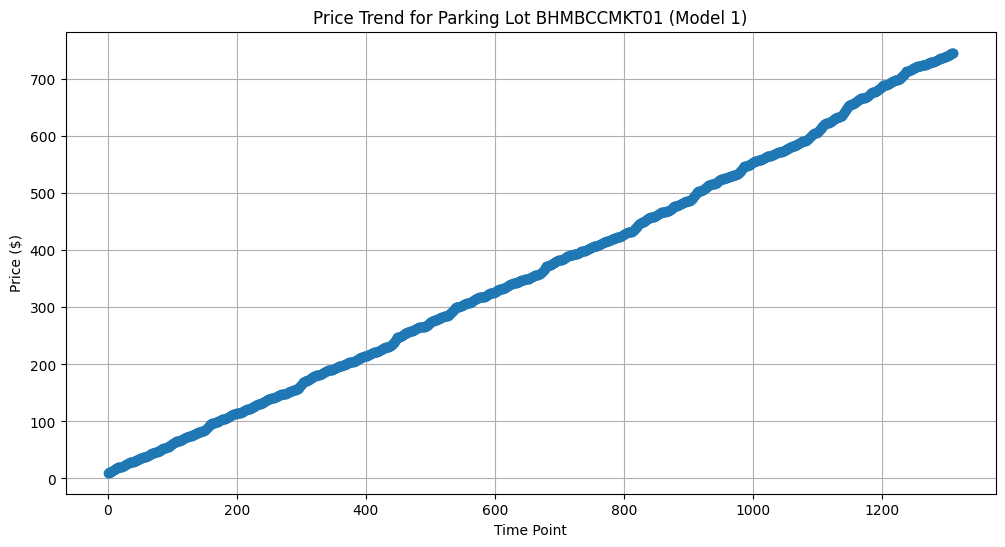

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(lot_data['Price_Model1'], marker='o', linestyle='-')
plt.title(f'Price Trend for Parking Lot {lot_id} (Model 1)')
plt.xlabel('Time Point')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()


In [ ]:
# Traffic Encoding: low=1, medium=2, high=3
traffic_mapping = {'low': 1, 'medium': 2, 'high': 3}
lot_data['TrafficEncoded'] = lot_data['TrafficConditionNearby'].map(traffic_mapping)

# Vehicle Type Encoding: car=1.0, bike=0.5, truck=1.5
vehicle_mapping = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
lot_data['VehicleEncoded'] = lot_data['VehicleType'].map(vehicle_mapping)

# Fill NaN values with the mean of the respective columns
lot_data['TrafficEncoded'].fillna(lot_data['TrafficEncoded'].mean(), inplace=True)
lot_data['VehicleEncoded'].fillna(lot_data['VehicleEncoded'].mean(), inplace=True)

# Normalize Demand later to 0-1

In [ ]:
# Coefficients (tune as needed)
alpha = 1.0   # Occupancy influence
beta = 0.5    # Queue influence
gamma = 0.3   # Traffic influence
delta = 1.0   # Special day influence
epsilon = 0.7 # Vehicle type influence

# Calculate demand
lot_data['Demand'] = (
    alpha * (lot_data['Occupancy'] / lot_data['Capacity']) +
    beta * lot_data['QueueLength'] -
    gamma * lot_data['TrafficEncoded'] +
    delta * lot_data['IsSpecialDay'] +
    epsilon * lot_data['VehicleEncoded']
)

# Check demand values
lot_data[['Occupancy', 'QueueLength', 'TrafficEncoded', 'IsSpecialDay', 'VehicleEncoded', 'Demand']].head()


,Occupancy,QueueLength,TrafficEncoded,IsSpecialDay,VehicleEncoded,Demand
0,50,1,1.000000,0,1.0,0.986655
1,54,1,1.000000,0,1.0,0.993588
2,69,2,1.699531,0,1.0,1.309725
3,91,1,1.000000,0,1.0,1.057712
4,135,3,1.699531,0,1.5,2.274110


In [ ]:
# Normalize demand to 0-1 range
demand_min = lot_data['Demand'].min()
demand_max = lot_data['Demand'].max()
lot_data['NormalizedDemand'] = (lot_data['Demand'] - demand_min) / (demand_max - demand_min)

# Apply pricing function
lambda_factor = 0.8  # scaling factor to control price sensitivity

lot_data['Price_Model2'] = base_price * (1 + lambda_factor * lot_data['NormalizedDemand'])

# Clip price to keep it between 0.5x and 2x base price
min_price = 0.5 * base_price
max_price = 2.0 * base_price
lot_data['Price_Model2'] = lot_data['Price_Model2'].clip(lower=min_price, upper=max_price)

# Show results
lot_data[['LastUpdatedDate', 'LastUpdatedTime', 'Occupancy', 'Price_Model2']].head(10)


,LastUpdatedDate,LastUpdatedTime,Occupancy,Price_Model2
0,01-11-2016,08:06:00,50,11.058582
1,01-11-2016,08:26:00,54,11.066580
2,01-11-2016,09:00:00,69,11.431293
3,01-11-2016,09:26:00,91,11.140558
4,01-11-2016,10:00:00,135,12.543859
5,01-11-2016,10:26:00,163,13.176670
6,01-11-2016,11:00:00,185,13.393704
7,01-11-2016,11:26:00,207,12.457085
8,01-11-2016,12:00:00,239,14.205238
9,01-11-2016,12:26:00,244,14.215235


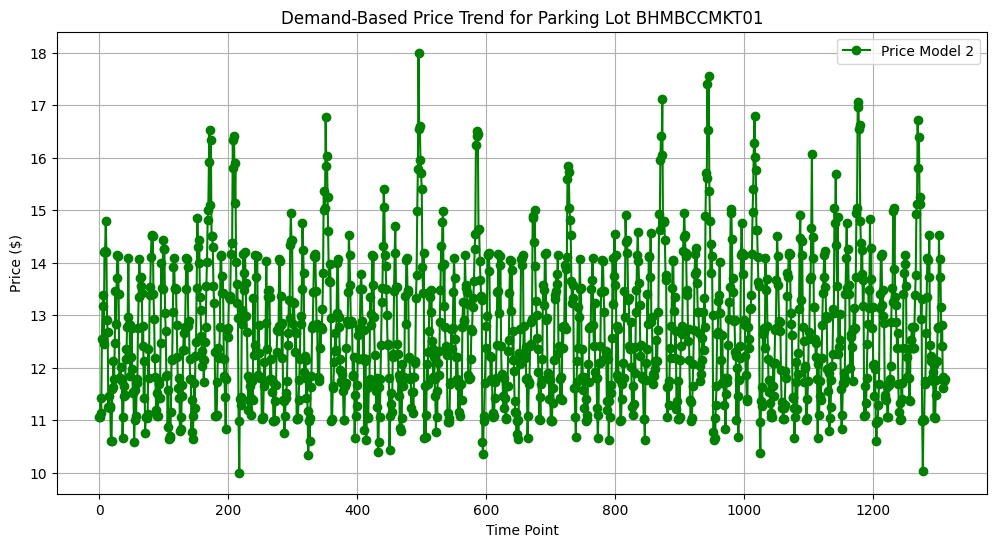

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(lot_data['Price_Model2'], marker='o', linestyle='-', color='green', label='Price Model 2')
plt.title(f'Demand-Based Price Trend for Parking Lot {lot_id}')
plt.xlabel('Time Point')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Haversine Distance Function (in km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Get unique parking lots with lat/lon
lots_info = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)

# Compute pairwise distances between lots
distance_matrix = pd.DataFrame(index=lots_info['SystemCodeNumber'], columns=lots_info['SystemCodeNumber'])

for i, lot1 in lots_info.iterrows():
    for j, lot2 in lots_info.iterrows():
        distance_matrix.loc[lot1['SystemCodeNumber'], lot2['SystemCodeNumber']] = haversine(
            lot1['Latitude'], lot1['Longitude'], lot2['Latitude'], lot2['Longitude']
        )

# Show distance matrix (in km)
distance_matrix.head()


SystemCodeNumber,BHMBCCMKT01,BHMBCCTHL01,BHMEURBRD01,BHMMBMMBX01,BHMNCPHST01,BHMNCPNST01,Broad Street,Others-CCCPS105a,Others-CCCPS119a,Others-CCCPS135a,Others-CCCPS202,Others-CCCPS8,Others-CCCPS98,Shopping
SystemCodeNumber,,,,,,,,,,,,,,
BHMBCCMKT01,0.0,0.005672,0.599291,1561.109931,0.720727,0.720084,0.87566,0.874107,0.884214,0.879303,0.879674,0.882273,0.881835,0.714036
BHMBCCTHL01,0.005672,0.0,0.601332,1561.111145,0.719883,0.719276,0.869992,0.878891,0.889012,0.884091,0.884458,0.887077,0.886619,0.719546
BHMEURBRD01,0.599291,0.601332,0.0,1561.611456,1.312779,1.311695,1.239031,1.156183,1.162867,1.160119,1.161054,1.160289,1.162787,0.618545
BHMMBMMBX01,1561.109931,1561.111145,1561.611456,0.0,1560.437718,1560.436676,1561.265895,1560.492437,1560.488164,1560.48953,1560.488406,1560.490799,1560.487065,1561.128021
BHMNCPHST01,0.720727,0.719883,1.312779,1560.437718,0.0,0.004633,1.023567,0.880156,0.889884,0.88441,0.88375,0.889911,0.885386,1.193499


In [ ]:
# Find 3 nearest competitors for our test lot (excluding itself)
target_lot = lot_id  # same lot as before
distances = distance_matrix[target_lot].astype(float).sort_values()

# Get top 3 competitors (excluding self)
nearest_lots = distances.index[1:4].tolist()
nearest_lots


['BHMBCCTHL01', 'BHMEURBRD01', 'Shopping']

In [ ]:
# Prepare competitor data
competitor_prices_list = []

# Coefficients (tune as needed) - Define these outside the loop if they are constant
alpha = 1.0   # Occupancy influence
beta = 0.5    # Queue influence
gamma = 0.3   # Traffic influence
delta = 1.0   # Special day influence
epsilon = 0.7 # Vehicle type influence
base_price = 10.0 # starting price
lambda_factor = 0.8 # scaling factor

for comp_lot in nearest_lots:
    comp_data = df[df['SystemCodeNumber'] == comp_lot].copy()

    # Ensure the same date and time format for merging
    comp_data['LastUpdatedDate'] = pd.to_datetime(comp_data['LastUpdatedDate'], format='%d-%m-%Y').dt.strftime('%d-%m-%Y')
    comp_data['LastUpdatedTime'] = pd.to_datetime(comp_data['LastUpdatedTime']).dt.strftime('%H:%M:%S')

    # Apply the same encoding and fillna as done for the main lot_data
    traffic_mapping = {'low': 1, 'medium': 2, 'high': 3}
    comp_data['TrafficEncoded'] = comp_data['TrafficConditionNearby'].map(traffic_mapping)
    vehicle_mapping = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
    comp_data['VehicleEncoded'] = comp_data['VehicleType'].map(vehicle_mapping)

    comp_data['TrafficEncoded'].fillna(comp_data['TrafficEncoded'].mean(), inplace=True)
    comp_data['VehicleEncoded'].fillna(comp_data['VehicleEncoded'].mean(), inplace=True)


    # Calculate demand for competitor data using the same model logic
    comp_data['Demand'] = (
        alpha * (comp_data['Occupancy'] / comp_data['Capacity']) +
        beta * comp_data['QueueLength'] -
        gamma * comp_data['TrafficEncoded'] +
        delta * comp_data['IsSpecialDay'] +
        epsilon * comp_data['VehicleEncoded']
    )

    # Normalize demand to 0-1 range for competitor data
    demand_min_comp = comp_data['Demand'].min()
    demand_max_comp = comp_data['Demand'].max()
    # Handle case where demand_max_comp and demand_min_comp are the same to avoid division by zero
    if demand_max_comp == demand_min_comp:
        comp_data['NormalizedDemand'] = 0
    else:
        comp_data['NormalizedDemand'] = (comp_data['Demand'] - demand_min_comp) / (demand_max_comp - demand_min_comp)


    # Apply pricing function for competitor data
    comp_data['Price_Model2'] = base_price * (1 + lambda_factor * comp_data['NormalizedDemand'])

    # Clip price to keep it between 0.5x and 2x base price for competitor data
    min_price = 0.5 * base_price
    max_price = 2.0 * base_price
    comp_data['Price_Model2'] = comp_data['Price_Model2'].clip(lower=min_price, upper=max_price)


    # Select only the necessary columns and rename price for merging
    comp_price_data = comp_data[['LastUpdatedDate', 'LastUpdatedTime', 'Price_Model2']].copy()
    comp_price_data.rename(columns={'Price_Model2': f'{comp_lot}_Price_Model2'}, inplace=True)
    competitor_prices_list.append(comp_price_data)

# Merge competitor prices with lot_data
# First, ensure lot_data has the correct date and time format for merging
lot_data['LastUpdatedDate'] = pd.to_datetime(lot_data['LastUpdatedDate'], format='%d-%m-%Y').dt.strftime('%d-%m-%Y')
lot_data['LastUpdatedTime'] = pd.to_datetime(lot_data['LastUpdatedTime']).dt.strftime('%H:%M:%S')

merged_data = lot_data.copy()
for comp_price_df in competitor_prices_list:
    merged_data = pd.merge(merged_data, comp_price_df, on=['LastUpdatedDate', 'LastUpdatedTime'], how='left')

# Show merged data with competitor prices
display(merged_data[['LastUpdatedDate', 'LastUpdatedTime'] + [f'{comp_lot}_Price_Model2' for comp_lot in nearest_lots]].head())

,LastUpdatedDate,LastUpdatedTime,BHMBCCTHL01_Price_Model2,BHMEURBRD01_Price_Model2,Shopping_Price_Model2
0,01-11-2016,08:06:00,10.000000,11.177484,10.544878
1,01-11-2016,08:26:00,11.095274,11.695478,11.314814
2,01-11-2016,09:00:00,10.768179,11.916885,11.432137
3,01-11-2016,09:26:00,11.421175,12.255306,11.886202
4,01-11-2016,10:00:00,12.057257,12.444786,12.814463


In [ ]:
# Occupancy threshold for "full"
occupancy_threshold = 0.9

# Adjust prices based on competitors
adjusted_prices = []

for idx in range(len(merged_data)):
    current_occupancy = merged_data.loc[idx, 'Occupancy'] / merged_data.loc[idx, 'Capacity']
    current_price = merged_data.loc[idx, 'Price_Model2']
    # Calculate the mean of competitor prices for the current time point, handling potential NaNs
    nearby_prices = merged_data.loc[idx, [f'{comp_lot}_Price_Model2' for comp_lot in nearest_lots]]
    nearby_avg_price = nearby_prices.astype(float).mean()


    # Example logic:
    if current_occupancy >= occupancy_threshold:
        if current_price > nearby_avg_price:
            new_price = nearby_avg_price  # Lower price to match nearby lots
        else:
            new_price = current_price * 0.95  # Small discount
    elif current_price < nearby_avg_price:
        new_price = min(current_price * 1.05, max_price)  # Slightly increase, bounded
    else:
        new_price = current_price  # Keep as is

    adjusted_prices.append(new_price)

# Save adjusted prices
merged_data['Price_Model3'] = adjusted_prices

# Show results
display(merged_data[['LastUpdatedDate', 'LastUpdatedTime', 'Price_Model2', 'Price_Model3']].head(10))

# Update lot_data to include Price_Model3 for plotting in the next cell
lot_data = merged_data.copy()

,LastUpdatedDate,LastUpdatedTime,Price_Model2,Price_Model3
0,01-11-2016,08:06:00,11.058582,11.058582
1,01-11-2016,08:26:00,11.066580,11.619909
2,01-11-2016,09:00:00,11.431293,11.431293
3,01-11-2016,09:26:00,11.140558,11.697586
4,01-11-2016,10:00:00,12.543859,12.543859
5,01-11-2016,10:26:00,13.176670,13.176670
6,01-11-2016,11:00:00,13.393704,13.393704
7,01-11-2016,11:26:00,12.457085,13.079940
8,01-11-2016,12:00:00,14.205238,14.915500
9,01-11-2016,12:26:00,14.215235,14.925997


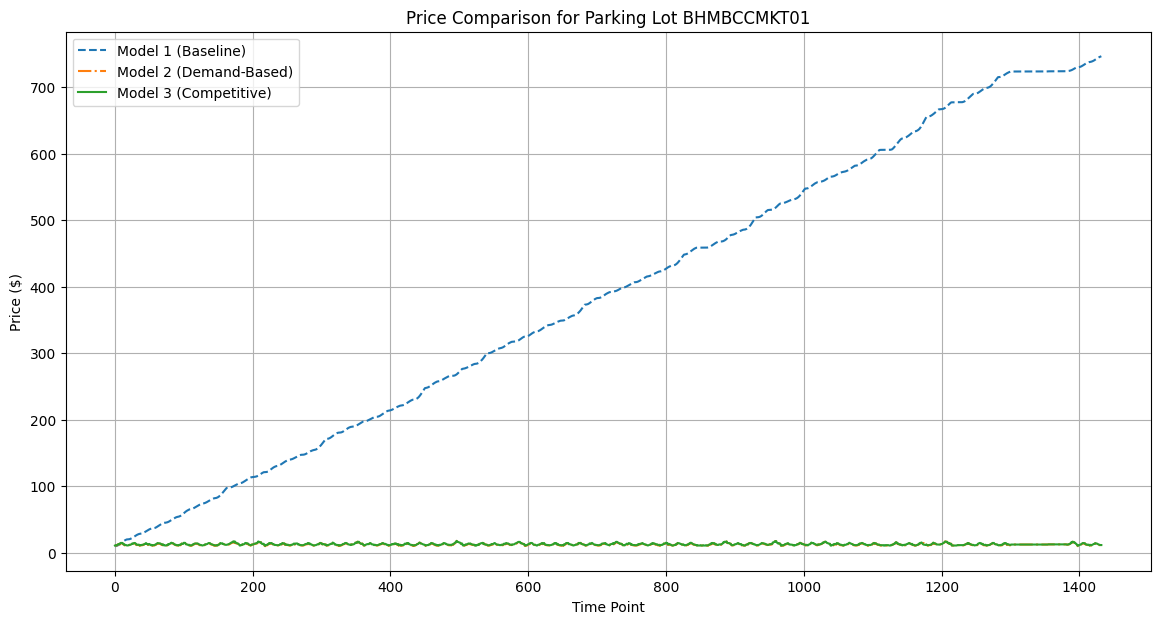

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(lot_data['Price_Model1'], label='Model 1 (Baseline)', linestyle='--')
plt.plot(lot_data['Price_Model2'], label='Model 2 (Demand-Based)', linestyle='-.')
plt.plot(lot_data['Price_Model3'], label='Model 3 (Competitive)', linestyle='-')
plt.title(f'Price Comparison for Parking Lot {lot_id}')
plt.xlabel('Time Point')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pathway as pw
import pandas as pd
import numpy as np


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathway as pw
import bokeh.plotting
import panel as pn


In [ ]:
df = pd.read_csv('dataset.csv')
import numpy as np
import pandas as pd
import pathway as pw
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
import time
df = pd.read_csv('/content/dataset.csv')  # Adjust your dataset filename here
df.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [ ]:
lot_id = 'BHMBCCMKT01'
lot_data = df[df['SystemCodeNumber'] == lot_id].copy()
lot_data = lot_data.sort_values(by=['LastUpdatedDate', 'LastUpdatedTime']).reset_index(drop=True)
lot_data.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,468,BHMBCCMKT01,577,26.144536,91.736172,50,car,low,1,0,01-11-2016,08:06:00
1,469,BHMBCCMKT01,577,26.144536,91.736172,54,car,low,1,0,01-11-2016,08:26:00
2,470,BHMBCCMKT01,577,26.144536,91.736172,69,car,average,2,0,01-11-2016,09:00:00
3,471,BHMBCCMKT01,577,26.144536,91.736172,91,car,low,1,0,01-11-2016,09:26:00
4,472,BHMBCCMKT01,577,26.144536,91.736172,135,truck,average,3,0,01-11-2016,10:00:00


In [ ]:
base_price = 10.0
alpha = 2.0
prices = [base_price]

for i in range(1, len(lot_data)):
    occupancy = lot_data.loc[i, 'Occupancy']
    capacity = lot_data.loc[i, 'Capacity']
    price_prev = prices[-1]
    price_new = price_prev + alpha * (occupancy / capacity)
    prices.append(price_new)

lot_data['Price_Model1'] = prices
lot_data[['LastUpdatedDate', 'LastUpdatedTime', 'Occupancy', 'Price_Model1']].head()


,LastUpdatedDate,LastUpdatedTime,Occupancy,Price_Model1
0,01-11-2016,08:06:00,50,10.000000
1,01-11-2016,08:26:00,54,10.187175
2,01-11-2016,09:00:00,69,10.426343
3,01-11-2016,09:26:00,91,10.741768
4,01-11-2016,10:00:00,135,11.209705


In [ ]:
output_notebook()
source = ColumnDataSource(data={
    'time_point': list(range(len(lot_data))),
    'price_model1': lot_data['Price_Model1'],
})

p = figure(title=f'Pricing Trend (Model 1) - Lot {lot_id}',
           x_axis_label='Time Point',
           y_axis_label='Price ($)',
           width=800, height=400) # Corrected attributes
p.line('time_point', 'price_model1', source=source, line_color='blue', line_width=2)
show(p)

In [ ]:
output_notebook()
source = ColumnDataSource(data={
    'time_point': list(range(len(lot_data))),
    'price_model1': lot_data['Price_Model1'],
})

p = figure(title=f'Pricing Trend (Model 1) - Lot {lot_id}',
           x_axis_label='Time Point',
           y_axis_label='Price ($)',
           width=800, height=400)
p.line('time_point', 'price_model1', source=source, line_color='blue', line_width=2)
show(p)

In [ ]:

!pip install pathway bokeh --quiet

import numpy as np
import pandas as pd
import pathway as pw
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
import time

df = pd.read_csv('/content/dataset.csv')  # Adjust dataset path if needed
df.head()

lot_id = 'BHMBCCMKT01'  # Example lot ID
lot_data = df[df['SystemCodeNumber'] == lot_id].copy()
lot_data = lot_data.sort_values(by=['LastUpdatedDate', 'LastUpdatedTime']).reset_index(drop=True)
lot_data.head()

base_price = 10.0
alpha = 2.0
prices = [base_price]

for i in range(1, len(lot_data)):
    occupancy = lot_data.loc[i, 'Occupancy']
    capacity = lot_data.loc[i, 'Capacity']
    price_prev = prices[-1]
    price_new = price_prev + alpha * (occupancy / capacity)
    prices.append(price_new)

lot_data['Price_Model1'] = prices
lot_data[['LastUpdatedDate', 'LastUpdatedTime', 'Occupancy', 'Price_Model1']].head()

output_notebook()
source = ColumnDataSource(data={
    'time_point': list(range(len(lot_data))),
    'price_model1': lot_data['Price_Model1'],
})

p = figure(title=f'Pricing Trend (Model 1) - Lot {lot_id}',
           x_axis_label='Time Point',
           y_axis_label='Price ($)',
           width=800, height=400) # Corrected attributes
p.line('time_point', 'price_model1', source=source, line_color='blue', line_width=2)
show(p)
